# Part 5 Modelling Text as a Sequence

## Introduction


While BoW-based models such as TF-IDF with Logistic Regression or SVM have shown decent performance, they inherently ignore the order and context of words in a sentence, which can limit model understanding of semantics. To address this, we experimented with Recurrent Neural Networks (RNNs), Long Short-Term Memory networks (LSTMs), and Gated Recurrent Units (GRUs), which are designed to process text as sequences.

## Data Representation

Text data was preprocessed using TensorFlow’s TextVectorization layer, which tokenized the text into integer sequences of fixed length (100). To evaluate the model's generalization, the vectorized data was then split into training and validation sets using an 80-20 split. This allowed the model to be trained on the majority of the data while still validating its performance on unseen examples. These sequences were then passed to an Embedding layer to produce dense word representations.

## Model Architectures

### Basic RNN

In [4]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
import tensorflow as tf

In [6]:
VOCAB_SIZE = 10000  # Number of unique words to keep
SEQUENCE_LENGTH = 100  # Fixed length of input sequences

In [7]:
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(100,), dtype=tf.int32),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, mask_zero=True),
    tf.keras.layers.SimpleRNN(128, return_sequences=True, dropout=0.2),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 100, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 681,541 (2.60 MB)

 Trainable params: 681,541 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

The model architecture consisted of two stacked SimpleRNN layers to deepen the network’s capacity for sequence modelling, followed by dense layers for classification:
- Embedding: Transforms integer sequences into 64-dimensional dense vectors.
- 	SimpleRNN: Two recurrent layers, the first returning sequences for the second.
-	Dense: Fully connected layers with ReLU activation and dropout to prevent overfitting.
-	Output layer uses softmax for multiclass classification (5 classes).
  
The model was compiled with categorical_crossentropy as the loss function and trained for 5 epochs. The dataset was preprocessed into padded sequences of length 100, and categorical labels were one-hot encoded.


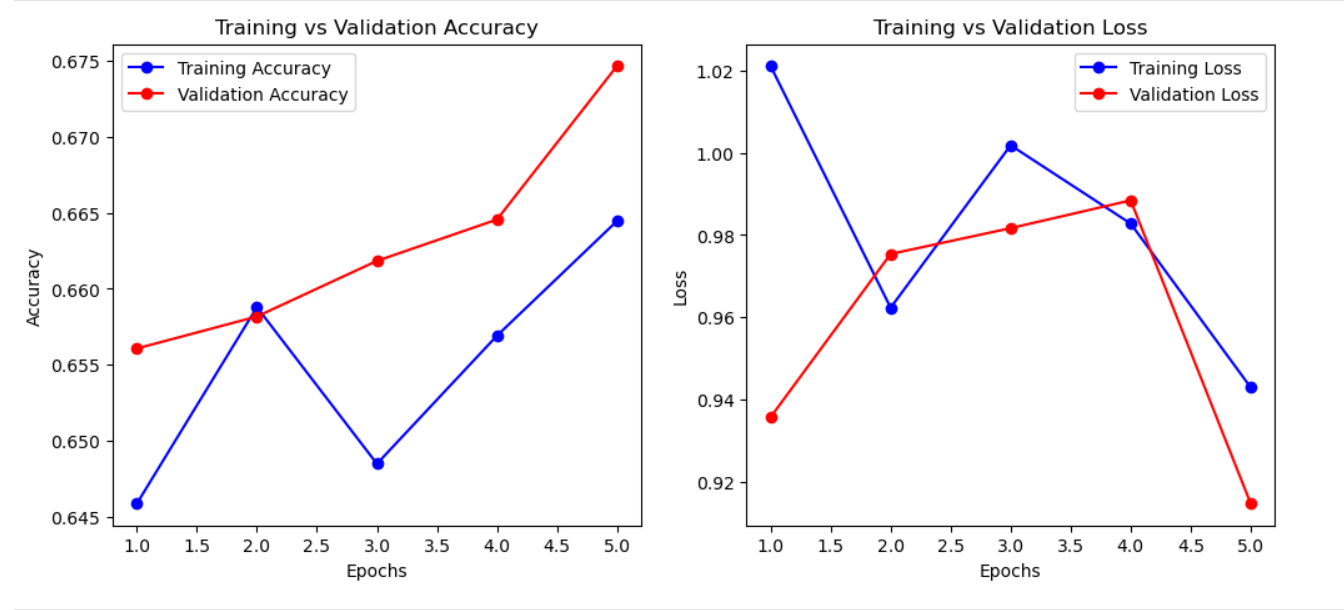

- Final Validation Accuracy: 67.46%
-	Kaggle Accuracy (on test set): 66.91%


Although the RNN showed reasonable performance, it plateaued early during training and validation, indicating limited capacity to model long-term dependencies. Compared to bag-of-words models (e.g., TF-IDF + SVM at ~73%), the RNN underperformed on the Kaggle test set. However, it served as a useful baseline for sequential modelling.

### GRU

GRU (Gated Recurrent Unit) networks are an improvement over basic RNNs, addressing the vanishing gradient problem by using gating mechanisms to better retain long-term dependencies.

In [8]:
model_gru = tf.keras.Sequential([
     tf.keras.layers.Input(shape=(100,), dtype=tf.int32),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True, recurrent_dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 256)            │         148,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 921,221 (3.51 MB)

 Trainable params: 921,221 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

The GRU model was implemented using two stacked Bidirectional GRU layers:
- Bidirectional GRU: Allows the model to access both past and future context.
-	Embedding: Maps integer tokens into 64-dimensional dense vectors.
-	Dropout: Used to regularize and prevent overfitting.
-	Final layer outputs class probabilities across 5 categories.


The model was trained for 5 epochs using the Adam optimizer and categorical_crossentropy loss. As with previous models, padded sequences of length 100 were used.

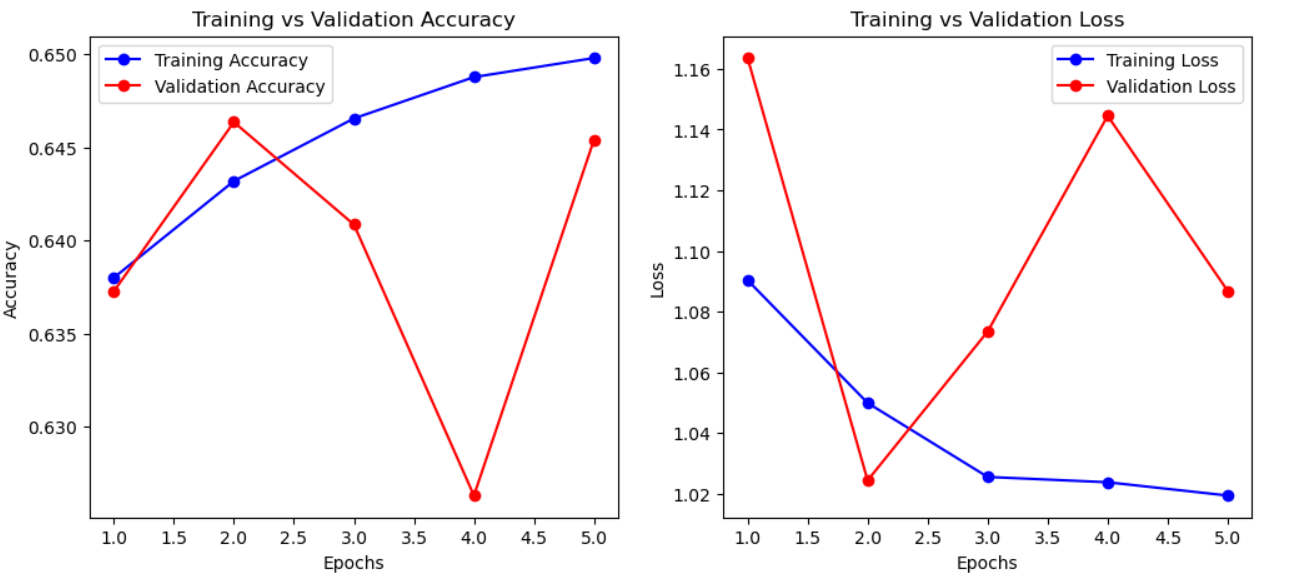

- Final Validation Accuracy: 64.54%
- Kaggle Accuracy: 64.14%

The GRU-based model performed slightly worse than the RNN baseline in terms of generalization, with validation accuracy showing fluctuations and no clear upward trend. The Kaggle score of 64.14% also trailed the RNN’s 66.91%. Despite GRUs being theoretically superior to simple RNNs in many tasks, they didn’t translate into clear gains in this experiment.


### LSTM

To better capture long-range dependencies in the text, we experimented with multiple LSTM architectures, varying both the depth of layers and number of training epochs. LSTMs are well-suited for sequential data as they mitigate the vanishing gradient problem and retain information over longer input sequences.
The best LSTM model was implemented using two stacked Bidirectional LSTM layers:


In [10]:
model_lstm11 = tf.keras.Sequential([
     tf.keras.layers.Input(shape=(100,), dtype=tf.int32),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_lstm11.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 100, 256)            │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,010,565 (3.85 MB)

 Trainable params: 1,010,565 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

- Bidirectional LSTM: This layer allows the model to process the input sequence in both forward and backward directions, capturing context from both past and future time steps. This helps the model understand the sequential dependencies in the data more effectively.
- Embedding Layer: The embedding layer maps integer tokens (word indices) into 64-dimensional dense vectors. These vectors capture semantic relationships between words and are learned during training.
- Dropout: A dropout rate of 0.3 was applied after the dense layer to help regularize the model and prevent overfitting. This technique randomly deactivates a fraction of the neurons during training to encourage more robust learning.
- Output Layer: The final dense layer with softmax activation outputs class probabilities across 5 categories. This allows the model to predict the class of an input sequence by assigning it a probability in one of the 5 categories.


The model was trained for 5 epochs using the Adam optimizer and categorical crossentropy loss. The input data consisted of padded sequences of length 100.

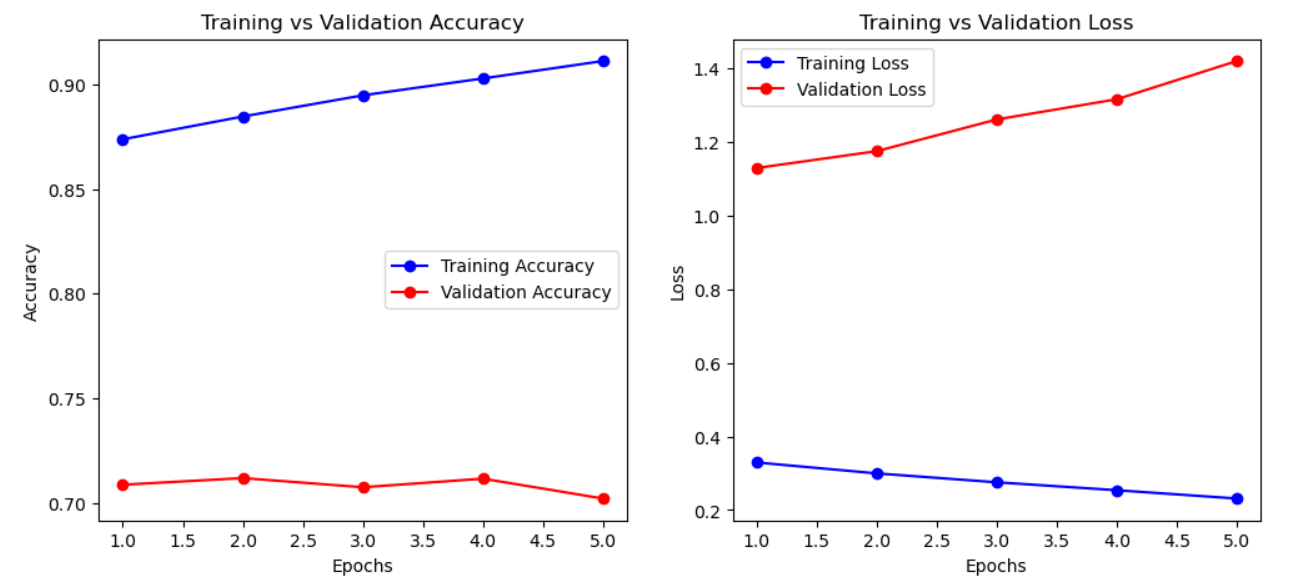

- Final Validation Accuracy: 70.21%
-	Kaggle Accuracy: 75.63%
  
The LSTM-based model performed the best, likely due to its ability to handle complex, long-term dependencies in text data, followed by GRU and Basic RNN in terms of both validation and Kaggle accuracy. However, depending on computational resources and real-time constraints, GRUs or Basic RNNs could still be viable alternatives for less complex tasks or where faster training is needed.


We experimented with multiple variations of LSTM models to determine the best architecture for classifying text data. The final table summarizes the key differences in architecture, performance metrics, and training conditions. These were the top 5 performing models based on Kaggle accuracy. For more details and to view the implementation of all the models, including basic RNN and GRU, please check the GitHub notebook.
https://github.com/athinsuresh/f20aa_cw2/blob/main/RNN.ipynb


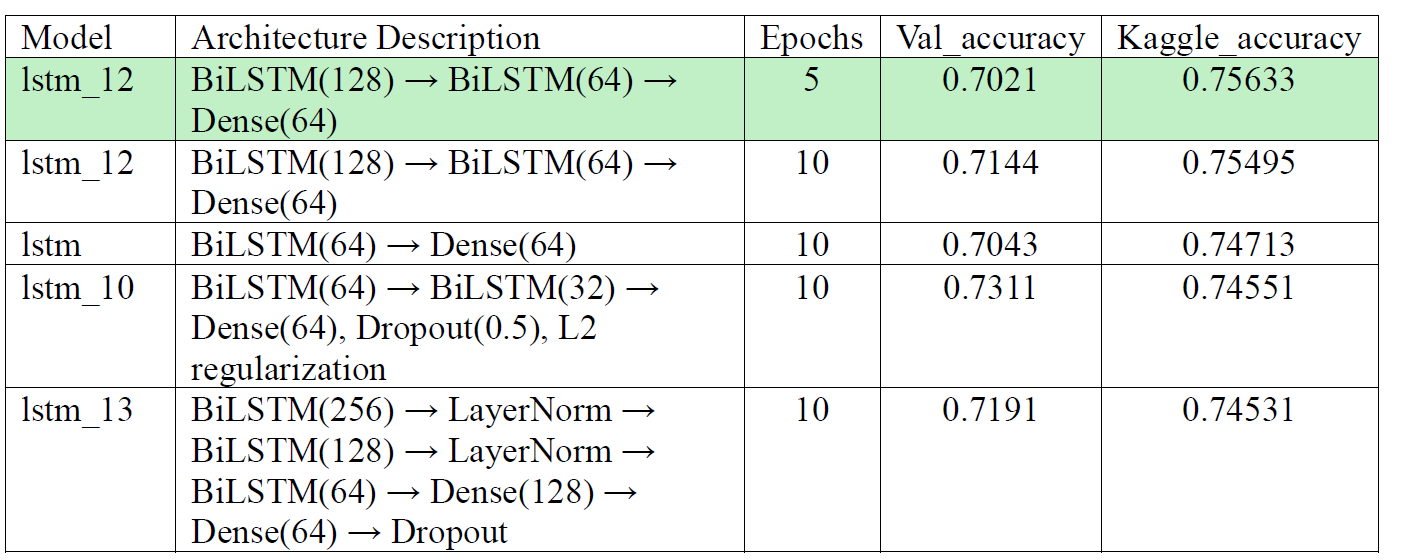

### DistilBERT

We also experimented with a pre-trained transformer model, specifically DistilBERT, which showed extremely promising results. During training, our validation accuracy reached as high as 0.89, indicating strong potential for generalization. However, the Kaggle notebook encountered a runtime crash around the 9th epoch—just one epoch short of completion—which prevented us from saving and using the final trained model. Due to time constraints, we were unable to retrain and recover the model before the submission deadline.

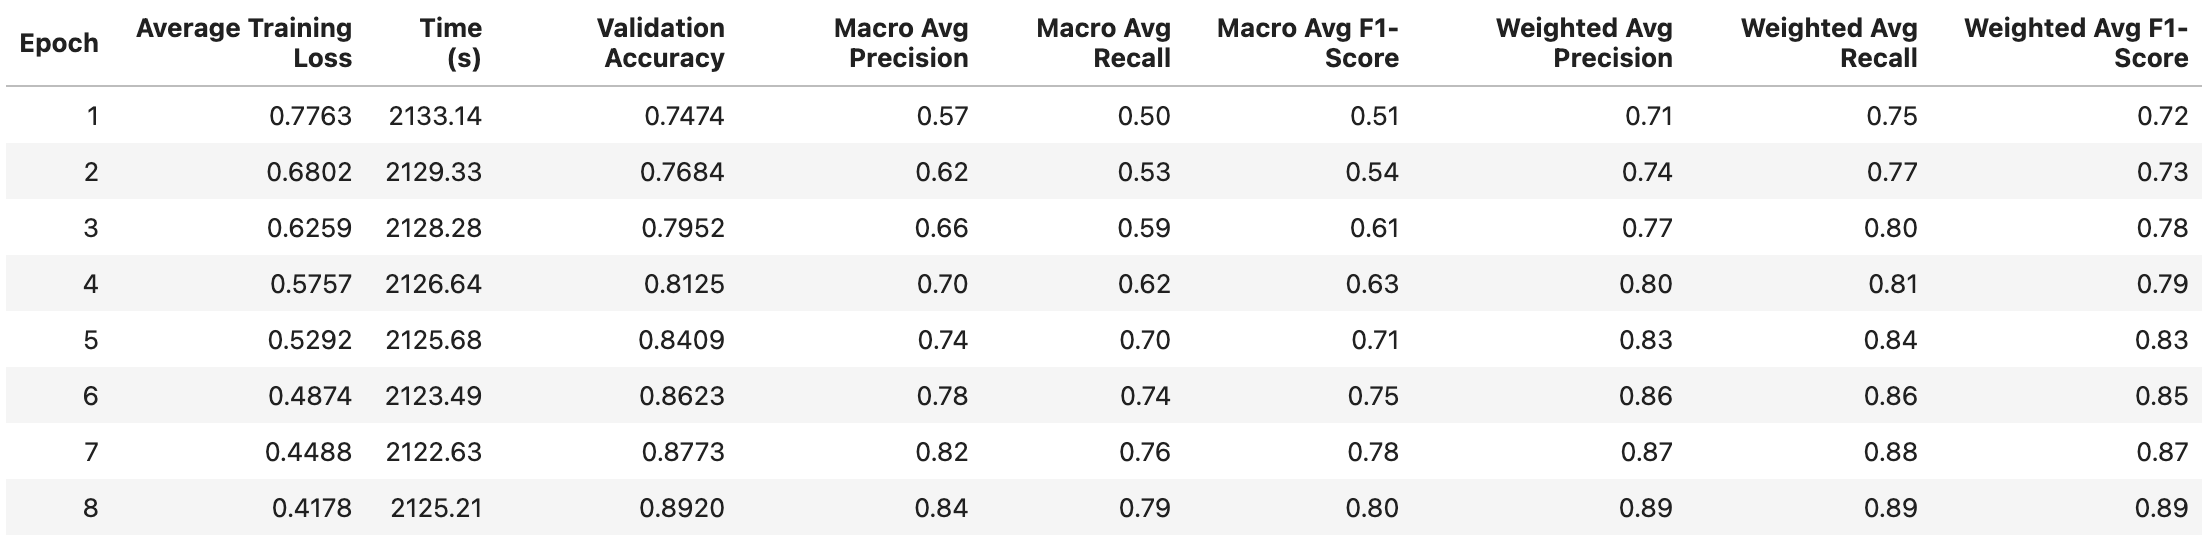

In [9]:
from IPython.display import Image, display
display(Image(filename='../Desktop/BERT Epoch.png'))